In [482]:
import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data Preparation

In the data preparation portion of this notebook, we subset the base training data and merge it with additional varaibles from the other given datasets. The goal is to use the additional datasets to create more variables to better determine if an applicant will struggle to pay back a loan. 

## Base Dataset

In [530]:
loans = pd.read_csv('https://www.dropbox.com/scl/fi/1ndeticw7z4n4vkwm21zc/application_train.csv?rlkey=fvx6hdqhg0fc1978szgz9x6e3&dl=1')

In [534]:
loans.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Here is the subset of variables we plan on trying to use from the base training data. The variables contain info about many different aspects of an applicant. 

In [535]:
usecols = ['SK_ID_CURR', # ID
           'NAME_EDUCATION_TYPE', # Education
           'CNT_FAM_MEMBERS', 'DEF_30_CNT_SOCIAL_CIRCLE', # Family/Friends
           'REGION_RATING_CLIENT_W_CITY', # Location
           'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', # Assets/Home
           'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', # Income/Job
           'AMT_CREDIT', # Loan Info
           'CODE_GENDER','DAYS_BIRTH', # Fairness 
           'TARGET' # Response Variable
          ]
train = loans[usecols].dropna().reset_index(drop=True)

#### Base Data Cleaning

In [536]:
def map_assets(res):
    if res == 'Y':
        return 1
    else:
        return 0

In [537]:
train['FLAG_OWN_CAR'] = train['FLAG_OWN_CAR'].apply(map_assets)
train['FLAG_OWN_REALTY'] = train['FLAG_OWN_REALTY'].apply(map_assets)

In [538]:
train.loc[:,'REGION_RATING_CLIENT_W_CITY'] = train['REGION_RATING_CLIENT_W_CITY'].astype(str)

## Previous Applications Dataset

In [539]:
prev_app = pd.read_csv('https://www.dropbox.com/scl/fi/la1qm68g32lil68hhqpuo/previous_application.csv?rlkey=s0qwfw8zbflsts0qlhx2va8lc&dl=1')

Here we are summarizing an applicants previous applications to gain more info about an applicants history. Some of the variables we are finding include how many prev applications has an applicant had, what was the average credit on those apps, how many were approved, canceled, refused, and unused.

In [540]:
df_prev_app_res = pd.concat([prev_app['SK_ID_CURR'], pd.get_dummies(prev_app['NAME_CONTRACT_STATUS'].str.upper(), dtype=int)], axis=1).groupby('SK_ID_CURR').sum()
df_prev_app_res['TOTAL_APPS'] = df_prev_app_res.sum(axis=1)
df_prev_app_res.reset_index(inplace=True)
df_temp = prev_app.groupby('SK_ID_CURR')['AMT_CREDIT'].mean().reset_index().rename(columns={'AMT_CREDIT':'AVG_PREV_AMT_CREDIT'})
prev_app_sum = df_prev_app_res.merge(df_temp, on='SK_ID_CURR')

In [541]:
prev_app_sum.head()

,SK_ID_CURR,APPROVED,CANCELED,REFUSED,UNUSED OFFER,TOTAL_APPS,AVG_PREV_AMT_CREDIT
0,100001,1,0,0,0,1,23787.0
1,100006,1,0,0,0,1,675000.0
2,100007,2,0,0,0,2,232200.0
3,100009,1,0,0,0,1,98239.5
4,100011,0,0,1,0,1,0.0


## Installments Payments Dataset

In [542]:
inst_pay = pd.read_csv('https://www.dropbox.com/scl/fi/24dt10upopn3zbg0m7otk/installments_payments.csv?rlkey=l9u1qhoy904tglaq8nng99adr&dl=1')

Here we are trying to gain insight into an applicants ability to pay different installments of previous credit. Some of the variables we calculate are how many late, ontime, no payment, insufficient, and full payments an applicant has.

In [543]:
inst_pay['N_LATE_PAY'] = (inst_pay['DAYS_ENTRY_PAYMENT'] > inst_pay['DAYS_INSTALMENT']).astype(int)
inst_pay['N_ONTIME_PAY'] = (inst_pay['DAYS_ENTRY_PAYMENT'] <= inst_pay['DAYS_INSTALMENT']).astype(int)
inst_pay['N_NO_PAYMENT'] = (inst_pay['AMT_PAYMENT'] == 0).astype(int)
inst_pay['N_PAYMENTS'] = pd.Series([1]*inst_pay.shape[0])
inst_pay['N_INSUF_PAYMENT'] = ((inst_pay['AMT_PAYMENT'] < (3/4)*inst_pay['AMT_INSTALMENT'])).astype(int)
inst_pay['N_FULL_PAYMENT'] = ((inst_pay['AMT_PAYMENT'] >= inst_pay['AMT_INSTALMENT'])).astype(int)
inst_pay_vars = inst_pay.groupby(['SK_ID_CURR'])[['N_LATE_PAY', 'N_ONTIME_PAY', 'N_NO_PAYMENT', 'N_PAYMENTS', 'N_INSUF_PAYMENT', 'N_FULL_PAYMENT']].sum().reset_index()

In [544]:
inst_pay_vars.head()

,SK_ID_CURR,N_LATE_PAY,N_ONTIME_PAY,N_NO_PAYMENT,N_PAYMENTS,N_INSUF_PAYMENT,N_FULL_PAYMENT
0,100001,1,6,0,7,0,7
1,100002,0,19,0,19,0,19
2,100003,0,25,0,25,0,25
3,100004,0,3,0,3,0,3
4,100005,1,8,0,9,0,9


## Credit Card Balance Dataset

In [545]:
cred_card = pd.read_csv('https://www.dropbox.com/scl/fi/360n45paoyg7jmcvtn0zd/credit_card_balance.csv?rlkey=gpekmyu1sy9na303yifydmn9b&dl=1')

Here we are doing the same as the installments payments dataset but for credit card loan payments. We calculate the number of days past due patments, ontime payments and total payments an applicant has

In [546]:
cred_card['N_DPD_CC'] = (cred_card['SK_DPD_DEF'] > 0).astype(int)
cred_card['N_ONTIME_CC'] = (cred_card['SK_DPD_DEF'] == 0).astype(int)
cred_card['N_PAYMENTS_CC'] = pd.Series([1]*cred_card.shape[0])
cred_card_vars = pd.DataFrame(cred_card.groupby('SK_ID_CURR')[['N_DPD_CC', 'N_ONTIME_CC', 'N_PAYMENTS_CC']].sum()).reset_index()

In [547]:
cred_card_vars.head()

,SK_ID_CURR,N_DPD_CC,N_ONTIME_CC,N_PAYMENTS_CC
0,100006,0,6,6
1,100011,0,74,74
2,100013,1,95,96
3,100021,0,17,17
4,100023,0,8,8


## POS CASH Balance

In [548]:
pos_cash = pd.read_csv('https://www.dropbox.com/scl/fi/ya687sh4v0s2jkavtwle1/POS_CASH_balance.csv?rlkey=3oypt1u95yj908y7kja3ourkm&dl=1')

In [549]:
pos_cash['N_COMPLETED_CONTRACTS'] = (pos_cash[pos_cash['CNT_INSTALMENT'] >= 12]['NAME_CONTRACT_STATUS'] == 'Completed').astype(int)
pos_cash_vars = pos_cash.groupby('SK_ID_CURR')['N_COMPLETED_CONTRACTS'].sum().reset_index()

In [550]:
pos_cash_vars.head()

,SK_ID_CURR,N_COMPLETED_CONTRACTS
0,100001,0.0
1,100002,0.0
2,100003,0.0
3,100004,0.0
4,100005,0.0


## Bureau Dataset

In [551]:
bureau = pd.read_csv('https://www.dropbox.com/scl/fi/b5y4piwjimd2qlsthvkud/bureau.csv?rlkey=yr1an067kgnz1q7k8dll46f9q&dl=1')

In [552]:
def map_credit_type(s):
    if s.lower() in ('real estate loan', 'mortgage'):
        return 'M'
    else:
        return 'O'

In [553]:
bureau_2 = bureau.loc[:, ['SK_ID_CURR', 'CREDIT_DAY_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'CREDIT_ACTIVE']].copy()
bureau_2['CREDIT_TYPE_GEN'] = bureau_2['CREDIT_TYPE'].astype(str).apply(map_credit_type)
bureau_2 = bureau_2[bureau_2['CREDIT_ACTIVE'] == "Active"].drop(['CREDIT_TYPE', 'CREDIT_ACTIVE'], axis=1).groupby(['SK_ID_CURR', 'CREDIT_TYPE_GEN']).sum().unstack().fillna(0)
bureau_2.columns = ['CREDIT_DAY_OVERDUE_MORTGAGE', 'CREDIT_DAY_OVERDUE_OTHER', 'AMT_CREDIT_SUM_OVERDUE_MORTGAGE', 'AMT_CREDIT_SUM_OVERDUE_OTHER']
bureau_2.reset_index(inplace=True)

In [554]:
bureau_2.head()

,SK_ID_CURR,CREDIT_DAY_OVERDUE_MORTGAGE,CREDIT_DAY_OVERDUE_OTHER,AMT_CREDIT_SUM_OVERDUE_MORTGAGE,AMT_CREDIT_SUM_OVERDUE_OTHER
0,100001,0.0,0.0,0.0,0.0
1,100016,0.0,0.0,0.0,0.0
2,100019,0.0,0.0,0.0,0.0
3,100020,0.0,0.0,0.0,0.0
4,100026,0.0,0.0,0.0,0.0


## Join Datasets

When joining the datasets, we made sure to use a left join so we do not lose observations that did not have data in the extra datasets. Therefore, if an applicant is not in these extra data tables, we will not be able to incorporate the additional information when predicting whether they will have difficulty paying back a loan.

In [555]:
train_full = train.merge(prev_app_sum, on='SK_ID_CURR', how='left').merge(inst_pay_vars, on='SK_ID_CURR', how='left').merge(cred_card_vars, on='SK_ID_CURR', how='left').merge(pos_cash_vars, on='SK_ID_CURR', how='left').merge(bureau_2, on='SK_ID_CURR', how='left')

In [556]:
train_full = train_full.fillna(0)

In [557]:
train_full.shape

(306488, 33)

In [558]:
train_full.head()

,SK_ID_CURR,NAME_EDUCATION_TYPE,CNT_FAM_MEMBERS,DEF_30_CNT_SOCIAL_CIRCLE,REGION_RATING_CLIENT_W_CITY,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,AMT_CREDIT,...,N_INSUF_PAYMENT,N_FULL_PAYMENT,N_DPD_CC,N_ONTIME_CC,N_PAYMENTS_CC,N_COMPLETED_CONTRACTS,CREDIT_DAY_OVERDUE_MORTGAGE,CREDIT_DAY_OVERDUE_OTHER,AMT_CREDIT_SUM_OVERDUE_MORTGAGE,AMT_CREDIT_SUM_OVERDUE_OTHER
0,100002,Secondary / secondary special,1.0,2.0,2,0,1,202500.0,Working,406597.5,...,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,Higher education,2.0,0.0,1,0,0,270000.0,State servant,1293502.5,...,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,Secondary / secondary special,1.0,0.0,2,1,1,67500.0,Working,135000.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,Secondary / secondary special,2.0,0.0,2,0,1,135000.0,Working,312682.5,...,0.0,16.0,0.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0
4,100007,Secondary / secondary special,1.0,0.0,2,0,1,121500.0,Working,513000.0,...,3.0,60.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0


# Model Fitting Functions

This section includes all the function used in testing/fitting the three different classification methods. 

Cross val contains many different methods for cross validation. The first method is regular k-fold CV. The second, stratified_target, allows us to mantain equal distribtuions of the target variable across testing and training splits. Additinally, "stratified" allows us to mantain an equal distribution of any target category across training and testing splits. This could potentially be used to stratify on age if we were to bin age into different categories.

In [199]:
def crossVal(model, X, Y, eta, numSplits, splitType, targetCats = None, cutoff = 0.5, prot_group_data=None):
    
    df_res = pd.DataFrame(columns=['metric', 'val'])
    splits = []

    if splitType == "k-fold":
        indicies = random.sample(list(range(0, len(X))), len(X))
        i = 0
        while i < numSplits:
            testIndicies = set(indicies[int((i/numSplits)*len(X)) : int((((i+1)/numSplits)*len(X)))])
            trainIndicies = set(indicies) - testIndicies
            splits.append((trainIndicies, testIndicies))
            i = i+1
    
    if splitType == "stratified_target":
        positiveSer = Y[Y == 1]
        negativeSer = Y[Y == 0]
        positiveIndicies = random.sample(list(positiveSer.index), len(positiveSer))
        negativeIndicies = random.sample(list(negativeSer.index), len(negativeSer))
        allIndicies = list(positiveIndicies.copy())
        allIndicies.extend(list(negativeIndicies))
        i = 0
        while i < numSplits:
            positiveTest = list(positiveIndicies[int((i/numSplits)*len(positiveIndicies)) : int((((i+1)/numSplits)*len(positiveIndicies)))])
            negativeTest = list(negativeIndicies[int((i/numSplits)*len(negativeIndicies)) : int((((i+1)/numSplits)*len(negativeIndicies)))])
            positiveTest.extend(negativeTest)
            testIndicies = set(positiveTest)
            trainIndicies = set(allIndicies) - testIndicies
            splits.append((trainIndicies, testIndicies))
            i = i+1

    if splitType == "resample":
        i = 0
        indicies = list(range(0, len(X)))
        while i < numSplits:
            testIndicies = set(list(random.sample(list(range(0, len(X))), int(len(X)/4))))
            trainIndicies = set(indicies) - testIndicies
            splits.append((trainIndicies, testIndicies))
            i = i+1

    if splitType == "stratified":
        indexGroups = []
        testSets = []
        indicies = list(X.groupby(targetCats).size().index)
        for index in indicies:
            indexGroups.append(list(X[(X[targetCats] == index).all(axis=1)].index))
        for group in indexGroups:
            testSets.append(random.sample(group, len(group)))
        allIndicies = list(range(0, len(X)))
        i = 0
        while i < numSplits:
            testIndicies = []
            for testSet in testSets:
                testIndicies.extend(list(testSet[int((i/numSplits)*len(testSet)) : int((((i+1)/numSplits)*len(testSet)))]))
            trainIndicies = set(allIndicies) - set(testIndicies)
            splits.append((trainIndicies, testIndicies))
            i = i+1

    if splitType == "targetOnly":
        indexGroups = []
        testSets = []
        indicies = list(X.groupby(targetCats).size().index)
        for index in indicies:
            indexGroups.append(list(X[(X[targetCats] == index).all(axis=1)].index))
        for group in indexGroups:
            testSets.append(random.sample(group, len(group)))
        allIndicies = list(range(0, len(X)))
        for testSet in testSets:
            testIndicies = list(testSet[0 : int(((.2)*len(testSet)))])
            trainIndicies = set(allIndicies) - set(testIndicies)
            splits.append((trainIndicies, testIndicies))


    for train, test in splits:
        train_x = X.iloc[list(train)].reset_index(drop=True)
        train_y = Y.iloc[list(train)].reset_index(drop=True)

        test_x = X.iloc[list(test)].reset_index(drop=True)
        test_y = Y.iloc[list(test)].reset_index(drop=True)
        
        if prot_group_data is not None:
            prot_group_data_test = prot_group_data[list(test)].reset_index(drop=True)
        else:
            prot_group_data_test = None
            
        df_res = pd.concat([df_res, fit_model(train_x, train_y, test_x, test_y, eta, model, cutoff=cutoff, prot_group_data=prot_group_data_test)], axis=0)
    
    
    return df_res.groupby('metric').mean().reset_index()

In [200]:
def roc_auc(Y, p):
    
    spec = []
    sens = []

    p = pd.Series(p).sort_values()
    
    for i, prob in enumerate(p):
        
        if (i != 0) and (i != len(p)-1):

            y_hat = (p > prob).astype(int)
            conf_matrix = pd.crosstab(Y, y_hat)

            tp = conf_matrix[1][1]
            tn = conf_matrix[0][0]
            fp = conf_matrix[1][0]
            fn = conf_matrix[0][1]

            spec += [tn / (tn + fp)]
            sens += [tp / (tp + fn)]

    return np.trapz(sens, spec)

In [242]:
def fit_model(train_x, train_y, test_x, test_y, eta, model, lam = 0, cutoff = .5, prot_group_data=None):
    
    if model == "logReg":
        betas = fit_logreg(train_x, train_y, eta, lam)
        z = test_x.to_numpy() @ betas
        p = 1 / (1 + np.exp((-1)*z))
        preds = (p > cutoff).astype(int)
        
    if model == "SVM":
        model = SVC(probability=True)
        model.fit(train_x, train_y)
        p = model.predict_proba(test_x)[:,1]
        preds = (p > cutoff).astype(int)
        
    if model == "LDA":
        model = LinearDiscriminantAnalysis()
        model.fit(train_x, train_y)
        p = model.predict_proba(test_x)[:,1]
        preds = (p > cutoff).astype(int)
        
    confusionMatrix = pd.crosstab(test_y, preds)
    
    df_res = pd.DataFrame(columns=['metric', 'val'])
    
    try:
        tp = confusionMatrix.at[1,1]
    except:
        tp = 0
    try:
        tn = confusionMatrix.at[0,0]
    except:
        tn = 0
    try:
        fp = confusionMatrix.at[0,1]
    except:
        fp = 0
    try:
        fn = confusionMatrix.at[1,0]
    except:
        fn = 0
    try:
        fdr = (fp / (fp + tp))
    except:
        fdr = None
    try:
        fnr = (fn / (fn + tp))
    except:
        fnr = None
    try:
        prec = (tp / (tp + fp))
    except:
        prec = None
    try:
        rec = (tp / (tp + fn))
    except:
        rec = None
        
    if prot_group_data is not None:
            
        protectedYesIndex = list(test_y[(test_y == 1) & (prot_group_data == 1)].index)
        unprotectedYesIndex = list(test_y[(test_y == 1) & (prot_group_data != 1)].index)
        protectedNoIndex = list(test_y[(test_y == 0) & (prot_group_data == 1)].index)
        unprotectedNoIndex = list(test_y[(test_y == 0) & (prot_group_data != 1)].index)

        probYesProtected = preds[protectedYesIndex].mean()
        probYesUnprotected = preds[unprotectedYesIndex].mean()
        tpr = probYesProtected/probYesUnprotected
        
        probNoProtected = preds[protectedNoIndex].mean()
        probNoUnprotected = preds[unprotectedNoIndex].mean()
        fpr = probNoUnprotected/probNoProtected
        
        res = [(2*tp)/(2*tp + fp + fn), (tp+tn)/(tp+tn+fp+fn), roc_auc(test_y, p), fdr, fnr, tpr, fpr, prec, rec]
        df_res['metric'] = pd.Series(['F1', 'Accuracy', 'ROC-AUC', 'False Discovery Rate', 'False Negative Rate', 'True Pos Rate', 'False Pos Rate', 'Precision', 'Recall'])
        df_res['val'] = pd.Series(res)
    
        
    else:
        res = [(2*tp)/(2*tp + fp + fn), (tp+tn)/(tp+tn+fp+fn), roc_auc(test_y, p), fdr, fnr, prec, rec]
        df_res['metric'] = pd.Series(['F1', 'Accuracy', 'ROC-AUC', 'False Discovery Rate', 'False Negative Rate', 'Precision', 'Recall'])
        df_res['val'] = pd.Series(res)
    
        
    return df_res

## Logistic Regression Function

In [202]:
def gradient(betas, X, c, p, lam):
  
    dl_dbeta = [0] * len(betas)

    for i in range(len(betas)):
        x = X.iloc[:,i]
        dl_dbeta[i] = ((-1)*c*(1-p)*x).sum() + ((1-c)*p*x).sum() + 2*lam*betas[i]
    
    return pd.Series(dl_dbeta)

def update_betas(betas, gradient, eta):
    return betas - eta*gradient

def check_stop_cond1(gradient):
    if max(gradient) <= 0.0001:
        return True
    else:
        return False

def check_stop_cond2(iter):
    if iter == 2000:
        return True
    else:
        return False

def fit_logreg(X, Y, eta, lam):
    iter = 0

    stop = False
    betas = pd.Series([0]*X.shape[1])

    while not stop:

        z = (X.to_numpy() @ betas.to_numpy())
        p = 1 / (1 + np.exp((-1)*z))
    
        dl_dbeta = gradient(betas, X, Y, p, lam)
        betas = update_betas(betas, dl_dbeta, eta)

        iter += 1

        eta = eta*.99

        stop = check_stop_cond1(dl_dbeta)
        stop = check_stop_cond2(iter)

    return betas.to_numpy()

# Model Fitting

In this section, we will test each type of classification model for different subsets of variables. The three classification models include Linear Regression, Support Vector Classfifier, and Linear Discriminant Analysis. 

In [450]:
train_full['TARGET'].value_counts(normalize=True)

TARGET
0    0.919119
1    0.080881
Name: proportion, dtype: float64

### Subset Data

We wanted to create a smaller subset of the data to test models on so code could be run more efficiently over different sets of variables. For the smaller subset, we took a 80/20 split of the target variable. The full data contains a rough 92/8 split of the response variable so our subset is more dense with respect to TARGET==1. 

Additionally we will be stratifying the data for cross validaiton with respect to the target to ensure the distribution of observations with TARGET==1 is equally spread across the folds. This is especially important given the imbalance between TARGET==0/1 in the data.

In [274]:
train_sub_pos = train_full[train_full['TARGET'] == 1].sample(2000).reset_index(drop=True)
train_sub_neg = train_full[train_full['TARGET'] == 0].sample(8000).reset_index(drop=True)

In [275]:
train_sub = pd.concat([train_sub_pos, train_sub_neg], axis=0)

## Logistic Regression

### Sub 1

In [236]:
ct1 = make_column_transformer(
    (OrdinalEncoder(), ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']),
    (StandardScaler(), ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'APPROVED', 'REFUSED', 'N_LATE_PAY', 'N_FULL_PAYMENT']),
    (OneHotEncoder(), ["NAME_EDUCATION_TYPE", 'NAME_INCOME_TYPE', 'REGION_RATING_CLIENT_W_CITY']),
    remainder="drop"
)

X = pd.DataFrame(ct1.fit_transform(train_sub))
Y = train_sub['TARGET']

In [237]:
crossVal('logReg', X, Y, .0002, 4, 'stratified_target', cutoff=.25)

,metric,val
0,Accuracy,0.629039
1,F1,0.388863
2,False Discovery Rate,0.502393
3,False Negative Rate,0.679189
4,Precision,0.497607
5,ROC-AUC,0.619514
6,Recall,0.320811


### Sub 2

In [238]:
ct2 = make_column_transformer(
    (OrdinalEncoder(), ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']),
    (StandardScaler(), ['DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'APPROVED', 'REFUSED', 'N_LATE_PAY', 'N_FULL_PAYMENT', 'N_COMPLETED_CONTRACTS', 'N_ONTIME_CC', 'N_DPD_CC']),
    (OneHotEncoder(), ["NAME_EDUCATION_TYPE", 'NAME_INCOME_TYPE', 'REGION_RATING_CLIENT_W_CITY', 'CODE_GENDER']),
    remainder="drop"
)

X = pd.DataFrame(ct2.fit_transform(train_sub))
Y = train_sub['TARGET']

In [239]:
crossVal('logReg', X, Y, .0002, 4, 'stratified_target', cutoff=.5)

,metric,val
0,Accuracy,0.631142
1,F1,0.023285
2,False Discovery Rate,0.221916
3,False Negative Rate,0.988154
4,Precision,0.778084
5,ROC-AUC,0.643126
6,Recall,0.011846


### Sub 3

In [243]:
ct3 = make_column_transformer(
    (OrdinalEncoder(), ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']),
    (StandardScaler(), ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'REGION_RATING_CLIENT_W_CITY', 'N_LATE_PAY', 'N_COMPLETED_CONTRACTS']),
    (OneHotEncoder(), ["NAME_EDUCATION_TYPE", 'NAME_INCOME_TYPE', 'REGION_RATING_CLIENT_W_CITY']),
    remainder="drop"
)

X = pd.DataFrame(ct3.fit_transform(train_sub))
Y = train_sub['TARGET']

In [244]:
crossVal('logReg', X, Y, .0002, 4, 'stratified_target', cutoff=.5)

,metric,val
0,Accuracy,0.631680
1,F1,0.000000
2,False Discovery Rate,1.000000
3,False Negative Rate,1.000000
4,Precision,0.000000
5,ROC-AUC,0.610827
6,Recall,0.000000


### Sub 4

In [245]:
ct4 = make_column_transformer(
    (OrdinalEncoder(), ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']),
    (StandardScaler(), ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'N_LATE_PAY', 'N_COMPLETED_CONTRACTS', 'CREDIT_DAY_OVERDUE_MORTGAGE', 'CREDIT_DAY_OVERDUE_OTHER',
       'AMT_CREDIT_SUM_OVERDUE_MORTGAGE', 'AMT_CREDIT_SUM_OVERDUE_OTHER']),
    (OneHotEncoder(), ["NAME_EDUCATION_TYPE", 'NAME_INCOME_TYPE', 'REGION_RATING_CLIENT_W_CITY']),
    remainder="drop"
)

X = pd.DataFrame(ct4.fit_transform(train_sub))
Y = train_sub['TARGET']

In [246]:
crossVal('logReg', X, Y, .0002, 4, 'stratified_target', cutoff=.5)

,metric,val
0,Accuracy,0.632527
1,F1,0.001735
2,False Discovery Rate,0.250000
3,False Negative Rate,0.999131
4,Precision,0.750000
5,ROC-AUC,0.610655
6,Recall,0.000869


### Sub 5

In [276]:
ct5 = make_column_transformer(
    (OrdinalEncoder(), ['FLAG_OWN_CAR']),
    (StandardScaler(), ['DAYS_BIRTH', 'REFUSED', 'N_ONTIME_PAY', 'N_PAYMENTS', 'DEF_30_CNT_SOCIAL_CIRCLE']),
    (OneHotEncoder(), ["NAME_EDUCATION_TYPE", 'NAME_INCOME_TYPE', 'REGION_RATING_CLIENT_W_CITY']),
    remainder="drop"
)

X = pd.DataFrame(ct5.fit_transform(train_sub))
Y = train_sub['TARGET']

In [248]:
crossVal('logReg', X, Y, .0002, 4, 'stratified_target', cutoff=.25)

,metric,val
0,Accuracy,0.631124
1,F1,0.430720
2,False Discovery Rate,0.498095
3,False Negative Rate,0.622407
4,Precision,0.501905
5,ROC-AUC,0.631738
6,Recall,0.377593


## SVC

### Sub 1

In [277]:
X = pd.DataFrame(ct1.fit_transform(train_sub))
Y = train_sub['TARGET']

In [278]:
crossVal('SVM', X, Y, .0002, 4, 'stratified_target', cutoff=.25)

,metric,val
0,Accuracy,0.627455
1,F1,0.036731
2,False Discovery Rate,0.579197
3,False Negative Rate,0.980714
4,Precision,0.420803
5,ROC-AUC,0.551428
6,Recall,0.019286


### Sub 2

In [279]:
X = pd.DataFrame(ct2.fit_transform(train_sub))
Y = train_sub['TARGET']

In [280]:
crossVal('SVM', X, Y, .0002, 4, 'stratified_target', cutoff=.25)

,metric,val
0,Accuracy,0.625900
1,F1,0.051749
2,False Discovery Rate,0.594659
3,False Negative Rate,0.972262
4,Precision,0.405341
5,ROC-AUC,0.546531
6,Recall,0.027738


### Sub 3

In [281]:
X = pd.DataFrame(ct3.fit_transform(train_sub))
Y = train_sub['TARGET']

In [282]:
crossVal('SVM', X, Y, .0002, 4, 'stratified_target', cutoff=.25)

,metric,val
0,Accuracy,0.628688
1,F1,0.032583
2,False Discovery Rate,0.538690
3,False Negative Rate,0.983030
4,Precision,0.461310
5,ROC-AUC,0.544372
6,Recall,0.016970


### Sub 4

In [283]:
X = pd.DataFrame(ct4.fit_transform(train_sub))
Y = train_sub['TARGET']

In [284]:
crossVal('SVM', X, Y, .0002, 4, 'stratified_target', cutoff=.25)

,metric,val
0,Accuracy,0.629788
1,F1,0.027410
2,False Discovery Rate,0.584310
3,False Negative Rate,0.985634
4,Precision,0.415690
5,ROC-AUC,0.549876
6,Recall,0.014366


### Sub 5

In [285]:
X = pd.DataFrame(ct5.fit_transform(train_sub))
Y = train_sub['TARGET']

In [286]:
crossVal('SVM', X, Y, .0002, 4, 'stratified_target', cutoff=.25)

,metric,val
0,Accuracy,0.630456
1,F1,0.021362
2,False Discovery Rate,0.723437
3,False Negative Rate,0.988761
4,Precision,0.276562
5,ROC-AUC,0.547511
6,Recall,0.011239


## LDA

### Sub 1

In [287]:
X = pd.DataFrame(ct1.fit_transform(train_sub))
Y = train_sub['TARGET']

In [288]:
crossVal('LDA', X, Y, .0002, 4, 'stratified_target', cutoff=.25)

,metric,val
0,Accuracy,0.639540
1,F1,0.425089
2,False Discovery Rate,0.484637
3,False Negative Rate,0.638066
4,Precision,0.515363
5,ROC-AUC,0.632198
6,Recall,0.361934


### Sub 2

In [289]:
X = pd.DataFrame(ct2.fit_transform(train_sub))
Y = train_sub['TARGET']

In [290]:
crossVal('LDA', X, Y, .0002, 4, 'stratified_target', cutoff=.25)

,metric,val
0,Accuracy,0.646788
1,F1,0.458219
2,False Discovery Rate,0.469278
3,False Negative Rate,0.595903
4,Precision,0.530722
5,ROC-AUC,0.648854
6,Recall,0.404097


### Sub 3

In [291]:
X = pd.DataFrame(ct3.fit_transform(train_sub))
Y = train_sub['TARGET']

In [292]:
crossVal('LDA', X, Y, .0002, 4, 'stratified_target', cutoff=.25)

,metric,val
0,Accuracy,0.628821
1,F1,0.408467
2,False Discovery Rate,0.504374
3,False Negative Rate,0.652270
4,Precision,0.495626
5,ROC-AUC,0.619167
6,Recall,0.347730


### Sub 4

In [293]:
X = pd.DataFrame(ct4.fit_transform(train_sub))
Y = train_sub['TARGET']

In [294]:
crossVal('LDA', X, Y, .0002, 4, 'stratified_target', cutoff=.25)

,metric,val
0,Accuracy,0.582643
1,F1,0.338686
2,False Discovery Rate,0.399030
3,False Negative Rate,0.595798
4,Precision,0.600970
5,ROC-AUC,0.614872
6,Recall,0.404202


### Sub 5

In [295]:
X = pd.DataFrame(ct5.fit_transform(train_sub))
Y = train_sub['TARGET']

In [296]:
crossVal('LDA', X, Y, .0002, 4, 'stratified_target', cutoff=.25)

,metric,val
0,Accuracy,0.642047
1,F1,0.445041
2,False Discovery Rate,0.482078
3,False Negative Rate,0.609377
4,Precision,0.517922
5,ROC-AUC,0.643419
6,Recall,0.390623


# Final Model

### Classification Model: Linear Discriminant Analysis
### Variable Set: Set 5

Variables: 

FLAG_OWN_CAR, DAYS_BIRTH, REFUSED, N_ONTIME_PAY, N_PAYMENTS, DEF_30_CNT_SOCIAL_CIRCLE, NAME_EDUCATION_TYPE, NAME_INCOME_TYPE, REGION_RATING_CLIENT_W_CITY

Here we are running the final model on a larger set of data with a more representative proportion of observations with TARGET==1 to guage performance

## Increased Subsample Size

In [297]:
train_sub2_pos = train_full[train_full['TARGET'] == 1].sample(20000).reset_index(drop=True)
train_sub2_neg = train_full[train_full['TARGET'] == 0].sample(180000).reset_index(drop=True)
train_sub2 = pd.concat([train_sub_pos, train_sub_neg], axis=0)

X = pd.DataFrame(ct5.fit_transform(train_sub2))
Y = train_sub2['TARGET']

In [298]:
crossVal('LDA', X, Y, .0002, 4, 'k-fold', cutoff=.5)

,metric,val
0,Accuracy,0.799200
1,F1,0.019238
2,False Discovery Rate,0.573214
3,False Negative Rate,0.990120
4,Precision,0.426786
5,ROC-AUC,0.643805
6,Recall,0.009880


In [299]:
crossVal('LDA', X, Y, .0002, 4, 'stratified_target', cutoff=.5)

,metric,val
0,Accuracy,0.634317
1,F1,0.021445
2,False Discovery Rate,0.405398
3,False Negative Rate,0.989067
4,Precision,0.594602
5,ROC-AUC,0.643184
6,Recall,0.010933


## Threshold Tuning

In [300]:
for i in range(5, 35, 5):
    print(f'Cutoff: {i/100}:')
    print(crossVal('LDA', X, Y, .0002, 4, 'stratified_target', cutoff=i/100))
    print()

Cutoff: 0.05:
                 metric       val
0              Accuracy  0.372055
1                    F1  0.540213
2  False Discovery Rate  0.629814
3   False Negative Rate  0.000851
4             Precision  0.370186
5               ROC-AUC  0.642477
6                Recall  0.999149

Cutoff: 0.1:
                 metric       val
0              Accuracy  0.419559
1                    F1  0.548637
2  False Discovery Rate  0.615939
3   False Negative Rate  0.039671
4             Precision  0.384061
5               ROC-AUC  0.643473
6                Recall  0.960329

Cutoff: 0.15:
                 metric       val
0              Accuracy  0.523855
1                    F1  0.557890
2  False Discovery Rate  0.575119
3   False Negative Rate  0.187046
4             Precision  0.424881
5               ROC-AUC  0.641439
6                Recall  0.812954

Cutoff: 0.2:
                 metric       val
0              Accuracy  0.609387
1                    F1  0.537267
2  False Discovery Rate  

Cutoff at 0.2 does well at balancing many of the different metrics. It has one of the largest F1-scores meaning it balances precision and recall very well. Additionally, it has one the larger values for accuracy, and keeps the false dicovery and false negative rate lower.

# Comparing LogReg, SVM, and LDA

In this section we compare the prediction results for LogReg, SVM, and LDA using the same variable set, data, and cutoff threshold.

In [451]:
train_sub_pos = train_full[train_full['TARGET'] == 1].sample(2000).reset_index(drop=True)
train_sub_neg = train_full[train_full['TARGET'] == 0].sample(8000).reset_index(drop=True)
train_sub = pd.concat([train_sub_pos, train_sub_neg], axis=0)

In [452]:
ct5 = make_column_transformer(
    (OrdinalEncoder(), ['FLAG_OWN_CAR']),
    (StandardScaler(), ['DAYS_BIRTH', 'REFUSED', 'N_ONTIME_PAY', 'N_PAYMENTS', 'DEF_30_CNT_SOCIAL_CIRCLE']),
    (OneHotEncoder(), ["NAME_EDUCATION_TYPE", 'NAME_INCOME_TYPE', 'REGION_RATING_CLIENT_W_CITY']),
    remainder="drop"
)

X = pd.DataFrame(ct5.fit_transform(train_sub))
Y = train_sub['TARGET']

In [470]:
splits = []

indicies = random.sample(list(range(0, len(X))), len(X))
i = 0
while i < numSplits:
    testIndicies = set(indicies[int((i/numSplits)*len(X)) : int((((i+1)/numSplits)*len(X)))])
    trainIndicies = set(indicies) - testIndicies
    splits.append((trainIndicies, testIndicies))
    i = i+1

Here we are fitting 3 models with the same variable sets and threshold to compare the predictions/predicted probabilities of each classification method.

In [476]:
i = 0
cutoff = 0.2
for train, test in splits:
    if i == 0:
        train_x = X.iloc[list(train)].reset_index(drop=True)
        train_y = Y.iloc[list(train)].reset_index(drop=True)

        test_x = X.iloc[list(test)].reset_index(drop=True)
        test_y = Y.iloc[list(test)].reset_index(drop=True)

        betas1 = fit_logreg(train_x, train_y, .0002, 0)
        z = test_x.to_numpy() @ betas1
        p1 = 1 / (1 + np.exp((-1)*z))
        preds1 = (p1 > cutoff).astype(int)
        
        model_svc = SVC(probability=True)
        model_svc.fit(train_x, train_y)
        p2 = model_svc.predict_proba(test_x)[:,1]
        preds2 = (p2 > cutoff).astype(int)
        
        model_lda = LinearDiscriminantAnalysis()
        model_lda.fit(train_x, train_y)
        p3 = model_lda.predict_proba(test_x)[:,1]
        preds3 = (p3 > cutoff).astype(int)
        
        i += 1

### Probabilities / Scores

(0.0, 0.6)

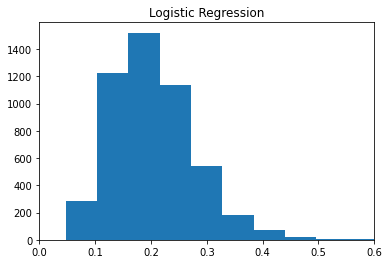

In [491]:
plt.hist(p1)
plt.title('Logistic Regression')
plt.xlim(0, 0.6)

(0.0, 0.6)

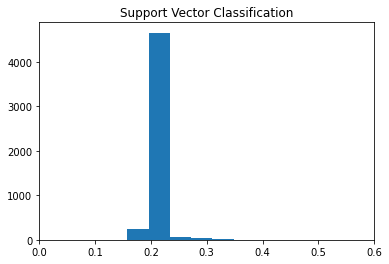

In [492]:
plt.hist(p2)
plt.title('Support Vector Classification')
plt.xlim(0, 0.6)

(0.0, 0.6)

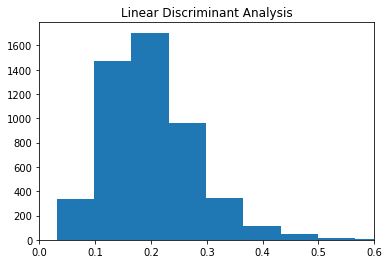

In [493]:
plt.hist(p3)
plt.title('Linear Discriminant Analysis')
plt.xlim(0, 0.6)

The histograms show the distribution of predicted scores/probabilities for each observation in the testing set for each of the three methods. We see LDA, and LogReg are the most similar with somewhat skewed right distributions. A majority of the predicted scores/proababilities are around 0.2 which was the choosen cutoff. LDA similarly has a majoirty of predictions around 0.2 however the scores/probas spread little from there. 

In [495]:
p1.mean(), p2.mean(), p3.mean()

(0.20393665273146144, 0.2028579613452813, 0.20054437706379932)

In [496]:
p1.std(), p2.std(), p3.std()

(0.07350896370241009, 0.01587892007277395, 0.07960131766803259)

Looking at the means, we see each model produced probabilites/scores centered around 0.2 which confirms what is seen in the plots. Additionally, we see the scores from SVC have little spread compared to LogReg and LDA. 

From this we see that SVC is struggling to separate the two groups (TARGET==0/1). One potential reason for this would be due to the imbalanced groups. It may be struggling to create separation between the groups because the TARGET==1 group is not dense enough to determine the best way to create group separation. 

### Predictions

In [512]:
df_preds = pd.DataFrame({'LogReg':pd.Series(preds1), 'SVC':pd.Series(preds2), 'LDA':pd.Series(preds3)})
df_preds.head()

,LogReg,SVC,LDA
0,0,0,0
1,1,1,1
2,1,0,1
3,1,1,1
4,0,0,1


In [516]:
df_preds.groupby(['LogReg', 'SVC', 'LDA']).value_counts()

LogReg  SVC  LDA
0       0    0      2627
             1        81
        1    0        96
             1        14
1       0    0       173
             1      1660
        1    0        12
             1       337
Name: count, dtype: int64

From the table we can see that SVC, LDA, and LogReg all tended to predict similar observations as 0. There were 2627 times where all three agreed on an observation prediction being 0. SVC on the other hand tended to still predict 0 when LogReg and LDA predicted 1. This happend 1660 times which is a significant difference. 

## Algorithm Comparison Conclusions

Overall, LogReg and LDA performed very similarly on this data. From the histograms we saw how the distributions of scores/probabilities were very similar for these two methods. Additionally, these models tended to produce similar predictions as seen in the table above.

SVC differed heavily from LogReg and LDA. SVC struggled to produce different/spread out scores and probabilities for the testing data. This is seen in the histogram of its scores/probabilities above. This led to SVC predicting TARGET == 0 for a vast majority of observations and disagreeing with LDA and LogReg when these models predicted TARGET == 1

# Fairness

In this section we will be exploring the fairness of different models by using females as the protected group.

Fairness can be incorporated into the cross validation code by including prot_group_data which is the column representing the protected group. The column should have values of 1 for obs in the protected group and 0 otherwise

## Fairness Metric = Equalized Odds


Equalized odds says that a fair classifier should make predictions about a protected group with the same true positive rate and false positive rate as the other group. Therefore equalized odds consists of two metrics, the true pos rate and false positive rate which compare the predictions for the protected group to the other group. 

A fair model should have both the True Pos Rate and False Pos Rate values above 0.80. A fair model across the groups would desire values close to 1. 

## Testing Fairness of Different Models

In [302]:
train_sub2_pos = train_full[train_full['TARGET'] == 1].sample(2000).reset_index(drop=True)
train_sub2_neg = train_full[train_full['TARGET'] == 0].sample(8000).reset_index(drop=True)
train_sub2 = pd.concat([train_sub_pos, train_sub_neg], axis=0)
prot_group = (train_sub2['CODE_GENDER'] == 'F').astype(int)

#### Best Predictive Model w/ Gender Included

In [303]:
ct6 = make_column_transformer(
    (OrdinalEncoder(), ['FLAG_OWN_CAR']),
    (StandardScaler(), ['DAYS_BIRTH', 'REFUSED', 'N_ONTIME_PAY', 'N_PAYMENTS', 'DEF_30_CNT_SOCIAL_CIRCLE']),
    (OneHotEncoder(), ["NAME_EDUCATION_TYPE", 'NAME_INCOME_TYPE', 'REGION_RATING_CLIENT_W_CITY', 'CODE_GENDER']),
    remainder="drop"
)

X = pd.DataFrame(ct6.fit_transform(train_sub2))
Y = train_sub2['TARGET']

In [304]:
crossVal('LDA', X, Y, .0002, 4, 'stratified_target', cutoff=.2, prot_group_data=prot_group)

,metric,val
0,Accuracy,0.614305
1,F1,0.542041
2,False Discovery Rate,0.519903
3,False Negative Rate,0.376203
4,False Pos Rate,1.059275
5,Precision,0.480097
6,ROC-AUC,0.650752
7,Recall,0.623797
8,True Pos Rate,1.059431


The results above are interesting. We see the False Pos Rate and True Pos Rate are still both close to 1. This means including gender does not compromise the fairness of the best predictive model. 

### LogReg Models

In [307]:
X = pd.DataFrame(ct5.fit_transform(train_sub2))
Y = train_sub2['TARGET']

crossVal('logReg', X, Y, .0002, 4, 'stratified_target', cutoff=.2, prot_group_data=prot_group)

,metric,val
0,Accuracy,0.593781
1,F1,0.532630
2,False Discovery Rate,0.537877
3,False Negative Rate,0.370711
4,False Pos Rate,0.899140
5,Precision,0.462123
6,ROC-AUC,0.638376
7,Recall,0.629289
8,True Pos Rate,0.992429


The logistic regression model using variable set 5 which was our optimal set produces another fiar model. We see both the False Pos rate and True pos rate are above 0.80.

In [305]:
X = pd.DataFrame(ct6.fit_transform(train_sub2))
Y = train_sub2['TARGET']

crossVal('logReg', X, Y, .0002, 4, 'stratified_target', cutoff=.2, prot_group_data=prot_group)

,metric,val
0,Accuracy,0.606369
1,F1,0.540987
2,False Discovery Rate,0.524680
3,False Negative Rate,0.371471
4,False Pos Rate,1.000128
5,Precision,0.475320
6,ROC-AUC,0.646699
7,Recall,0.628529
8,True Pos Rate,0.987097


The model using Logistic Regression with the same variable set including gender is extremely fair according to equalized odds across gender.

## Fairness for our best predictive Model

In [51]:
X = pd.DataFrame(ct5.fit_transform(train_sub2))
Y = train_sub2['TARGET']

In [53]:
crossVal('LDA', X, Y, .0002, 4, 'stratified_target', cutoff=.2, prot_group_data=prot_group)

,metric,val
0,Accuracy,0.601005
1,F1,0.526430
2,False Discovery Rate,0.532138
3,False Negative Rate,0.397757
4,False Pos Rate,0.950426
5,Precision,0.467862
6,ROC-AUC,0.634791
7,Recall,0.602243
8,True Pos Rate,1.005951


Looking at the False Pos Rate and the True Pos Rate, our best predictive model is very fair. The True Pos Rate and False Pos Rate are both very close to 1 indicating the model predictions are very similar for males and females. 

### Fairness vs Threshold

In [306]:
for i in range(5, 35, 5):
    print(f'Cutoff: {i/100}:')
    print(crossVal('LDA', X, Y, .0002, 4, 'stratified_target', cutoff=i/100, prot_group_data=prot_group))
    print()

Cutoff: 0.05:
                 metric       val
0              Accuracy  0.371762
1                    F1  0.538658
2  False Discovery Rate  0.631287
3   False Negative Rate  0.000570
4        False Pos Rate  0.999294
5             Precision  0.368713
6               ROC-AUC  0.651276
7                Recall  0.999430
8         True Pos Rate  1.000287

Cutoff: 0.1:
                 metric       val
0              Accuracy  0.427138
1                    F1  0.550701
2  False Discovery Rate  0.613252
3   False Negative Rate  0.043894
4        False Pos Rate  1.004713
5             Precision  0.386748
6               ROC-AUC  0.652100
7                Recall  0.956106
8         True Pos Rate  0.994966

Cutoff: 0.15:
                 metric       val
0              Accuracy  0.542336
1                    F1  0.566825
2  False Discovery Rate  0.563112
3   False Negative Rate  0.192238
4        False Pos Rate  0.993376
5             Precision  0.436888
6               ROC-AUC  0.649567
7    

From the results above, we see the fairness of the model is fairly constant across different thresholds. We see that the false pos rate and true pos rate are consistently above 0.8 and close to 1. 

## Final Fairness Analysis

Because our best predictive model was also extremely fair when examining females as a protected group when looking at equalized odds, there were no sacrifices needing to be made with respect to the predictive performance of the model. Additoinal models that were tested to examine fairness also produced very good results with respect to fairness however none of these models were able to be significantly more fair than our best predictive model and top its prediction performance. 